# Задача Титаник
#### Емельянова Анастасия, 475 группа

## 1. Описание задачи
Датасет состоит из пассажиров Титаника и нкоторой информации о них. Цель задачи - спрогнозировать, спасется человек или нет. 
Есть пояснения по данным:
* PassengerId — идентификатор пассажира
* Survival — поле в котором указано спасся человек (1) или нет (0)
* Pclass — содержит социально-экономический статус:
    1. высокий
    2. средний
    3. низкий
* Name — имя пассажира
* Sex — пол пассажира
* Age — возраст
* SibSp — содержит информацию о количестве родственников 2-го порядка (муж, жена, братья, сетры)* 
* Parch — содержит информацию о количестве родственников на борту 1-го порядка (мать, отец, дети)
* Ticket — номер билета
* Fare — цена билета
* Cabin — каюта
* Embarked — порт посадки
    - C — Cherbourg
    - Q — Queenstown
    - S — Southampton


_Выгрузим данные_

In [1]:
from pandas import read_csv, DataFrame, Series, concat
data = read_csv('train.csv')

In [2]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


_Применим "метод внимательного вглядывания" к данным. Поищим зависимости_

_Предположение: чем человек более знатный, тем больше вероятность выживания_

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
data.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(kind='bar', stacked=True)

_Да. Чем выше класс - тем более высок процент выживания_

_Есть ли зависимость между выживаемостю и наличием/кол-вом родствеников?_

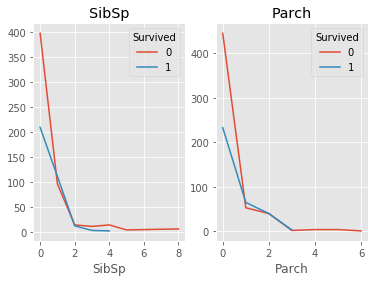

In [4]:
fig, axes = plt.subplots(ncols=2)
data.pivot_table('PassengerId', ['SibSp'], 'Survived', 'count').plot(ax=axes[0], title='SibSp')
data.pivot_table('PassengerId', ['Parch'], 'Survived', 'count').plot(ax=axes[1], title='Parch')

_А что у нас вообще с заполняемостью данных?_

In [5]:
overview = concat([data.dtypes, data.isnull().sum()], axis=1)
overview.columns = ["type", "NAs"]
overview

,type,NAs
PassengerId,int64,0
Survived,int64,0
Pclass,int64,0
Name,object,0
Sex,object,0
Age,float64,177
SibSp,int64,0
Parch,int64,0
Ticket,object,0
Fare,float64,0


_Даннные о каютах заполнены меньше чем на четверь. Игнорировать колонку._
_Колонки порт посадки и возраст использовать можно, но нужно придумать что делать с неуказанными данными_

In [6]:
data.Age = data.Age.median()
MaxPassEmbarked = data.groupby('Embarked').count()['PassengerId']
data.Embarked[data.Embarked.isnull()] = MaxPassEmbarked[MaxPassEmbarked == MaxPassEmbarked.max()].index[0]

/home/cheburek/voron/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
overview = concat([data.dtypes, data.isnull().sum()], axis=1)
overview.columns = ["type", "NAs"]
overview

,type,NAs
PassengerId,int64,0
Survived,int64,0
Pclass,int64,0
Name,object,0
Sex,object,0
Age,float64,0
SibSp,int64,0
Parch,int64,0
Ticket,object,0
Fare,float64,0


_Двух пассажиров "посадили" в порт, где село большинство пассажиров. Людям без возраста был присвоен средний возраст._

_По имени-фамилии можно выяснить родственников, но данные нам выше уже показали, что большое кол-во выживших имело 0-1 родственника. Игнорируем колонку.
Цена билета - важна, некая градация бедные/богатые
Номер билета - не вижу пути применения.
Итак_

In [8]:
data = data.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,28.0,1,0,7.2500,S
1,1,1,female,28.0,1,0,71.2833,C
2,1,3,female,28.0,0,0,7.9250,S
3,1,1,female,28.0,1,0,53.1000,S
4,0,3,male,28.0,0,0,8.0500,S


_Теперь закодируем текстовые значения полей пола и порта посадки_

In [9]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
dicts = {}

label.fit(data.Sex.drop_duplicates()) #задаем список значений для кодирования
dicts['Sex'] = list(label.classes_)
data.Sex = label.transform(data.Sex) #заменяем значения из списка кодами закодированных элементов 

label.fit(data.Embarked.drop_duplicates())
dicts['Embarked'] = list(label.classes_)
data.Embarked = label.transform(data.Embarked)

In [10]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,28.0,1,0,7.2500,2
1,1,1,0,28.0,1,0,71.2833,0
2,1,3,0,28.0,0,0,7.9250,2
3,1,1,0,28.0,1,0,53.1000,2
4,0,3,1,28.0,0,0,8.0500,2


_Данные готовы для использования. Однако, у нас еще имеется тестовая выборка, "причешем" и ее._

In [11]:
test = read_csv('test.csv')

In [12]:
overview = concat([test.dtypes, test.isnull().sum()], axis=1)
overview.columns = ["type", "NAs"]
overview

,type,NAs
PassengerId,int64,0
Pclass,int64,0
Name,object,0
Sex,object,0
Age,float64,86
SibSp,int64,0
Parch,int64,0
Ticket,object,0
Fare,float64,1
Cabin,object,327


_Порт отправления есть у всех, но у одного нету цены билета. Присвоем ему среднюю_

In [13]:
test.Age[test.Age.isnull()] = test.Age.mean()
test.Fare[test.Fare.isnull()] = test.Fare.median()

label.fit(dicts['Sex'])
test.Sex = label.transform(test.Sex)

label.fit(dicts['Embarked'])
test.Embarked = label.transform(test.Embarked)

/home/cheburek/voron/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/cheburek/voron/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,2
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,2


In [15]:
MaxPassEmbarked = test.groupby('Embarked').count()['PassengerId']
test.Embarked[test.Embarked.isnull()] = MaxPassEmbarked[MaxPassEmbarked == MaxPassEmbarked.max()].index[0]
result = DataFrame(test.PassengerId)
test = test.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)

/home/cheburek/voron/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,1
1,3,0,47.0,1,0,7.0000,2
2,2,1,62.0,0,0,9.6875,1
3,3,1,27.0,0,0,8.6625,2
4,3,0,22.0,1,1,12.2875,2


## 2. Решение
Будем применять базовые алгоритмы классификации к нашим данным. Метод k ближайших соседей, случайный лес, логистическая регрессия
Проверка: кросс-валидация, ROC-AUX

In [17]:
from sklearn import cross_validation, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import pylab as pl

/home/cheburek/voron/my_env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
target = data.Survived
train = data.drop(['Survived'], axis=1) #из исходных данных убираем Id пассажира и флаг спасся он или нет
kfold = 5 #количество подвыборок для валидации
itog_val = {} #список для записи результатов кросс валидации разных алгоритмов

In [19]:
ROCtrainTRN, ROCtestTRN, ROCtrainTRG, ROCtestTRG = cross_validation.train_test_split(train, target, test_size=0.25) 

In [20]:
model_rfc = RandomForestClassifier(n_estimators = 70) #в параметре передаем кол-во деревьев
model_knc = KNeighborsClassifier(n_neighbors = 18) #в параметре передаем кол-во соседей
model_lr = LogisticRegression(penalty='l1', tol=0.01) 

In [21]:
scores = cross_validation.cross_val_score(model_rfc, train, target, cv = kfold)
itog_val['RandomForestClassifier'] = scores.mean()
scores = cross_validation.cross_val_score(model_knc, train, target, cv = kfold)
itog_val['KNeighborsClassifier'] = scores.mean()
scores = cross_validation.cross_val_score(model_lr, train, target, cv = kfold)
itog_val['LogisticRegression'] = scores.mean()

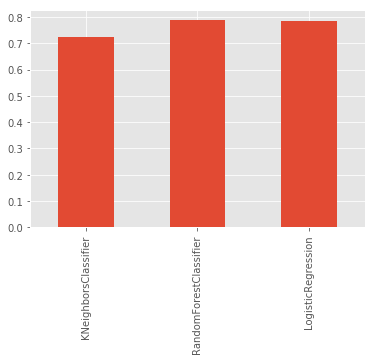

In [22]:
DataFrame.from_dict(data = itog_val, orient='index').plot(kind='bar', legend=False)

_Лучшими показателями обладяет случайный лес_

<Figure size 432x288 with 0 Axes>

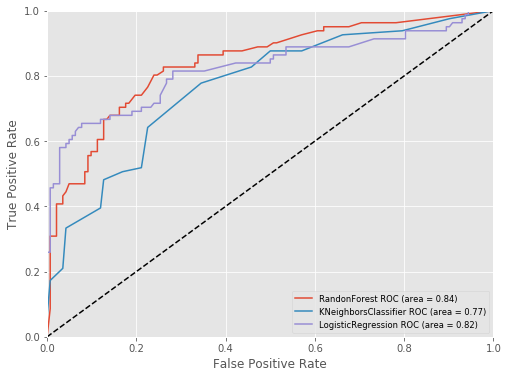

In [23]:
pl.clf()
plt.figure(figsize=(8,6))

#RandomForestClassifier
probas = model_rfc.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)
fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RandonForest',roc_auc))
#KNeighborsClassifier
probas = model_knc.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)
fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('KNeighborsClassifier',roc_auc))
#LogisticRegression
probas = model_lr.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)
fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LogisticRegression',roc_auc))
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

_Так же случайный лес показывает лучший результат_

In [24]:
itog_val['RandomForestClassifier']

0.7879959727454591

In [25]:
probas = model_rfc.fit(ROCtrainTRN, ROCtrainTRG).predict_proba(ROCtestTRN)
fpr, tpr, thresholds = roc_curve(ROCtestTRG, probas[:, 1])
roc_auc  = auc(fpr, tpr)

In [26]:
roc_auc

0.8354199269692227

### 3. Ссылка на гитхаб
https://github.com/Drakohka95/voron